źródło:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality

## Data Set Information:

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link] or the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

## Attribute Information:

1 - fixed acidity

2 - volatile acidity

3 - citric acid

4 - residual sugar

5 - chlorides

6 - free sulfur dioxide

7 - total sulfur dioxide

8 - density

9 - pH

10 - sulphates

11 - alcohol

Output variable (based on sensory data):

12 - quality (score between 0 and 10)



# Wczytywanie danych
## normalizacja, podział na zbiory treningowe i testowe

In [1]:
# import libraries
import numpy as np
import pandas as pd
import copy

# path depends on where jupyter notebook was started from
import os
print(f'working directory: {os.getcwd()}')
RED_WINE_PATH = r'./wine-quality-classification/baza_danych/winequality-red.csv'
WHITE_WINE_PATH = r'./wine-quality-classification/baza_danych/winequality-white.csv'

# how much of all loaded samples will be designated as testing set (rest will be training set)
PERCENT_OF_SAMPLES_AS_TEST = 0.2

# will loaded data be normalized
NORMALIZE_DATA = True

ALL_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ALL_FEATURES_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ALL_FEATURES_NAMES = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol'
]


# define classes
class Wine:
    
    def __init__(self, name, filename, shuffle=False, asTest=PERCENT_OF_SAMPLES_AS_TEST, normalize=NORMALIZE_DATA):
        self.name = name
        self.true_column = 'quality'
        self.pred_column = 'predicted_quality'
        self.excluded_columns = [self.true_column, self.pred_column]
        with open(filename, 'rb') as f:
            data_csv = pd.read_csv (f, sep=';')
            self.df = pd.DataFrame(data_csv)
            self.df['predicted_quality'] = 0

            self.columns = list(self.df.columns)
            self.parameters = [c for c in self.columns if c not in self.excluded_columns]

            if shuffle:
                self.df = self.df.sample(frac = 1)
            
            self.split_to_train_test(asTest)

            if normalize:
                self.normalize()

            self.quantities = {}
            self.train_quantities = {}

            self.train_populated_classes = []
            self.populated_classes = []

            for c in ALL_CLASSES:
                self.quantities[c] = len(self.df[self.df.quality.isin([c])])
                self.train_quantities[c] = len(self.train[self.train.quality.isin([c])])

                if self.quantities[c] > 0:
                    self.populated_classes.append(c)
                if self.train_quantities[c] > 0:
                    self.train_populated_classes.append(c)

            

    def split_to_train_test(self, asTest):
        self.train = self.df.copy()
        self.test = self.df.copy()
        train_count = int(len(self.df) * (1-asTest))
        self.train = self.train.drop(list(range(train_count+1, len(self.train))))
        self.test = self.test.drop(list(range(0, train_count)))

    def normalize(self):
        self.train, min_max_from_train = Wine.normalize_dataframe(self.train, excludeCols=self.excluded_columns)
        self.test, dont_care = Wine.normalize_dataframe(self.test, excludeCols=self.excluded_columns, minMax=min_max_from_train)

    def normalize_dataframe(df, excludeCols, minMax=None):
        if(minMax is None):
            minMax = {}
            for col in list(df.columns):
                _min = min(df[col])
                _max = max(df[col])
                minMax[col] = {'min': _min, 'max': _max}

        for col in list(df.columns):
            if col not in excludeCols:
                _min = minMax[col]['min']
                _max = minMax[col]['max']
                df[col] = df[col].apply(lambda x: (x-_min)/(_max-_min))
        return df, minMax

    def print_stats(self):
        

        print(f'{self.name} all samples    = {len(self.df)}')
        print(f'{self.name} train samples  = {len(self.train)}')
        print(f'{self.name} test samples   = {len(self.test)}')
        print(f'{self.name} sample quantity by class (quality): ')
        print(self.quantities)
        print(f'{self.name} populated classes: {self.populated_classes}')
        print(f'{self.name} populated classes (train set): {self.train_populated_classes}')
        print()
        



working directory: C:\Users\janje\OneDrive\mgr-sem1\SMPD\laboratorium\wine-quality-classification\projekt


In [2]:
# load data

# temp
# RED_WINE_PATH =  r'../baza_danych/winequality-red.csv'
# WHITE_WINE_PATH =  r'../baza_danych/winequality-white.csv'

red_wine = Wine('red_wine', RED_WINE_PATH)
white_wine = Wine('white_wine', WHITE_WINE_PATH)

red_wine.print_stats()
white_wine.print_stats()


if red_wine.columns == white_wine.columns:
    FEATURES = red_wine.parameters
    print(f'features ({len(red_wine.parameters)}): \n {red_wine.parameters}')
else:
    print('error: different columns in files')





red_wine all samples    = 1599
red_wine train samples  = 1280
red_wine test samples   = 320
red_wine sample quantity by class (quality): 
{0: 0, 1: 0, 2: 0, 3: 10, 4: 53, 5: 681, 6: 638, 7: 199, 8: 18, 9: 0, 10: 0}
red_wine populated classes: [3, 4, 5, 6, 7, 8]
red_wine populated classes (train set): [3, 4, 5, 6, 7, 8]

white_wine all samples    = 4898
white_wine train samples  = 3919
white_wine test samples   = 980
white_wine sample quantity by class (quality): 
{0: 0, 1: 0, 2: 0, 3: 20, 4: 163, 5: 1457, 6: 2198, 7: 880, 8: 175, 9: 5, 10: 0}
white_wine populated classes: [3, 4, 5, 6, 7, 8, 9]
white_wine populated classes (train set): [3, 4, 5, 6, 7, 8, 9]

features (11): 
 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


# Selekcja cech


In [3]:
print(white_wine.train['quality'].min())
print(red_wine.train['quality'].min())

3
3


In [4]:
print(white_wine.train['quality'].max())
print(red_wine.train['quality'].max())

9
8


In [5]:
from itertools import combinations
import math 

class FeatureSelector():
    def __init__(self):
        self.fisher_factors_fc = {}
        self.debug = True
        
    def euclidean_distance(self, row1, row2):
        return math.sqrt(
            sum([(row1[i] - row2[i]) ** 2 for i in range(len(row1))])
        )
    
    def get_mean_vector(self, train):
        
        return np.atleast_2d(train.mean(1)).T
    
    def get_covariance(self, dataset, mean):
        n = len(dataset[0])
        m = np.tile(mean, (1, n))
        
        x = np.subtract(dataset, m)
    
        return 1/(n-1) * np.dot(x, x.T)
    
    def get_fisher_factors(self, train_1,  train_2):
        mean_1 = self.get_mean_vector(train_1)
        mean_2 = self.get_mean_vector(train_2)
        
        covariance_1 = self.get_covariance(train_1, mean_1)
        covariance_2 = self.get_covariance(train_2, mean_2)
        
        return np.divide(self.euclidean_distance(mean_1, mean_2), np.trace(covariance_1 + covariance_2))
        
    
    def select(self, wine, class_ids, feature_ids, min_number_of_features, max_number_of_features, balanced=True):
        train = wine.train
        # Dla podanej ilości cech utwórz wszystkie możliwe kombinacje
        features_combinations = []
        for i in range(min_number_of_features, max_number_of_features+1):
            l = list(combinations(feature_ids, i))
            for combination in l:
                features_combinations.append(combination)

        
        class_combinatinos = list(combinations(class_ids, 2))
        
        # Wyznacz współczynniki Fishera dla każdej pary klas i każdej kombinacji cech
        for features_combination in features_combinations:
            fisher_factors = {}
            for class_combination in class_combinatinos:

                if balanced:
                    # im wieksza licznosc tych klas, tym bardziej chcemy aby latwiej je bylo rozroznic
                    quantity_factor = 1
                    q = wine.train_quantities[class_combination[0]] + wine.train_quantities[class_combination[1]]
                    quantity_factor = (q**2) / len(wine.train)
                     
                train_samples_1 = train.loc[train['quality'] == class_combination[0]].to_numpy()
                train_samples_2 = train.loc[train['quality'] == class_combination[1]].to_numpy()
                
                train_samples_1_t = train_samples_1[:, features_combination].T
                train_samples_2_t = train_samples_2[:, features_combination].T
                
                if balanced:
                    fisher_factors[class_combination] = quantity_factor * self.get_fisher_factors(train_samples_1_t, train_samples_2_t)
                else:
                    fisher_factors[class_combination] = self.get_fisher_factors(train_samples_1_t, train_samples_2_t)

            self.fisher_factors_fc[features_combination] = sum(fisher_factors.values()) / len(fisher_factors)
                
                
        
        # Określ która kombinacja cech jest najlepsza dla wybranych cech
        best_features = [key for key, value in self.fisher_factors_fc.items() if self.fisher_factors_fc[key] == max(self.fisher_factors_fc.values())]
        return best_features

In [6]:
# Select best features for white wine samples
class_ids = [5, 6, 7] # white_wine.train_populated_classes
# number_of_features = 5

fs = FeatureSelector()
best_white_wine_features = fs.select(white_wine, class_ids, ALL_FEATURES_IDS, 2, 2)
best_white_wine_features = list(*best_white_wine_features)
white_wine.best_features = best_white_wine_features

print('best features for white wine:')
for f in white_wine.best_features:
    print(f'feature: id={f} - {ALL_FEATURES_NAMES[f]}')

best features for white wine:
feature: id=4 - chlorides
feature: id=7 - density


In [7]:
# Select best features for red wine samples
class_ids = [5, 6, 7] # red_wine.train_populated_classes
# number_of_features = 5

fs = FeatureSelector()
best_red_wine_features = fs.select(red_wine, class_ids, ALL_FEATURES_IDS, 2, 2)
best_red_wine_features = list(*best_red_wine_features)
red_wine.best_features = best_red_wine_features

print('best features for red wine:')
for f in red_wine.best_features:
    print(f'feature: id={f} - {ALL_FEATURES_NAMES[f]}')

best features for red wine:
feature: id=4 - chlorides
feature: id=10 - alcohol


# Klasyfikacja

In [8]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, cohen_kappa_score, balanced_accuracy_score

def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred), cohen_kappa_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)

def wine_score(y_true, y_pred):
    if len(y_true) == len(y_pred):
        total_score = 0
        for i in range(0, len(y_pred)):
            error = abs(y_pred[i] - y_true[i])
            score = 0
            # if error == 0, then 100% good
            # if error == 1, then wrong by 1 quality score
            # and so on
            if error == 0:
                score = 1
            # here, only difference between this score, and 'accuracy_score'
            if error == 1:
                score = 0.5
            if error > 2:
                score = 0
            
            total_score += score
        total_score = total_score / len(y_pred)
        return total_score
    return None

# Train data with selected features (X)
white_wine_train = white_wine.train.iloc[:, best_white_wine_features]
red_wine_train = red_wine.train.iloc[:, best_red_wine_features]

# Test data with selected features
white_wine_test = white_wine.test.iloc[:, best_white_wine_features]
red_wine_test = red_wine.test.iloc[:, best_red_wine_features]

# Target values (y)
white_wine_target = white_wine.train['quality']
red_wine_target = red_wine.train['quality']

# Test target
test_white_wine_target = white_wine.test['quality']
test_red_wine_target = red_wine.test['quality']

def print_results(title, y_true, y_pred):
    acc = get_accuracy(y_true, y_pred)
    wine_acc = wine_score(y_true, y_pred)
    print(f' === {title} ===')
    print(f'Accuracy Score:      {100*acc[0]:8.2f}%')
    print(f'Cohen Kappa Score:   {100*acc[1]:8.2f}%')
    print(f'Balanced Acc. Score: {100*acc[2]:8.2f}%')
    print(f'Our Score:           {100*wine_acc:8.2f}%')

def nearest_neighbor_classifier(wine):
    train = wine.train.iloc[:, wine.best_features]
    target = wine.train['quality']

    test = wine.test.iloc[:, wine.best_features]
    test_target = wine.test['quality']


    neighbors = KNeighborsClassifier(n_neighbors=1)
    neighbors.fit(train, target)
    y_pred = neighbors.predict(test)
    y_true = test_target.to_numpy()
    return y_true, y_pred 

def k_nearest_neighbor_classifier(wine, k):
    train = wine.train.iloc[:, wine.best_features]
    target = wine.train['quality']

    test = wine.test.iloc[:, wine.best_features]
    test_target = wine.test['quality']

    neighbors = KNeighborsClassifier(n_neighbors=k)
    neighbors.fit(train, target)
    y_pred = neighbors.predict(test)
    y_true = test_target.to_numpy()
    return y_true, y_pred  

def nearest_mean_classifier(wine):
    train = wine.train.iloc[:, wine.best_features]
    target = wine.train['quality']

    test = wine.test.iloc[:, wine.best_features]
    test_target = wine.test['quality']

    clf = NearestCentroid()
    clf.fit(train, target)
    y_pred = clf.predict(test)
    y_true = test_target.to_numpy()
    return y_true, y_pred  


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def draw_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    

    class_ids = []
    for c in y_true:
        if c not in class_ids:
            class_ids.append(c)
    for c in y_pred:
        if c not in class_ids:
            class_ids.append(c)
    class_ids = sorted(class_ids)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.ylabel('Quality')
    plt.xlabel('Predicted quality')

    tick_marks = np.arange(len(class_ids))
    plt.xticks(tick_marks, class_ids, rotation=45)
    plt.yticks(tick_marks, class_ids)

    for i in range(len(class_ids)):
        for j in range(len(class_ids)):
            plt.text(j, i, str(cm[i][j]))
        
    plt.show()

In [9]:
# Finding best feature combination
# feature_ids = ALL_FEATURES_IDS
# class_ids_white = white_wine.train_populated_classes
# class_ids_red = red_wine.train_populated_classes
#for n in range(2, 9):    
#    number_of_features = n

#    fs = FeatureSelector()
#    best_white_wine_features = fs.select(white_wine.train, class_ids_white, feature_ids, number_of_features)
#    best_white_wine_features = list(*best_white_wine_features)
#    best_red_wine_features = fs.select(red_wine.train, class_ids_red, feature_ids, number_of_features)
#    best_red_wine_features = list(*best_red_wine_features)
    
    # Train data with selected features (X)
#    white_wine_train = white_wine.train.iloc[:, best_white_wine_features]
#    red_wine_train = red_wine.train.iloc[:, best_red_wine_features]

    # Test data with selected features
#    white_wine_test = white_wine.test.iloc[:, best_white_wine_features]
#    red_wine_test = red_wine.test.iloc[:, best_red_wine_features]
    
    # NN
#    print(f'NN White wine - featutres: {best_white_wine_features}')
#    white_wine_pred = nearest_neighbor_classifier(white_wine_train, white_wine_target, white_wine_test, test_white_wine_target)
#    print(f'NN Red wine - features: {best_red_wine_features}')
#    red_wine_pred = nearest_neighbor_classifier(red_wine_train, red_wine_target, red_wine_test, test_red_wine_target)

In [10]:
#best_white_wine_features = [0, 2, 3, 4, 7, 10]
#best_red_wine_features = [1, 3, 4, 6, 9, 10]

# Train data with selected features (X)
# white_wine_train = white_wine.train.iloc[:, best_white_wine_features]
# red_wine_train = red_wine.train.iloc[:, best_red_wine_features]

# # Test data with selected features
# white_wine_test = white_wine.test.iloc[:, best_white_wine_features]
# red_wine_test = red_wine.test.iloc[:, best_red_wine_features]

# # Target values (y)
# white_wine_target = white_wine.train['quality']
# red_wine_target = red_wine.train['quality']

# # Test target
# test_white_wine_target = white_wine.test['quality']
# test_red_wine_target = red_wine.test['quality']

In [11]:
# Red wine best number of neighbors (BEST k = 10)
# for i in range(1, 21):
    # print(f'k:{i}')
    # k_nearest_neighbor_classifier(i, red_wine_train, red_wine_target, red_wine_test, test_red_wine_target)

In [12]:
# White wine best number of neighbors (BEST k = 19)
#for i in range(1, 21):
    #print(f'k:{i}')
    #k_nearest_neighbor_classifier(i, white_wine_train, white_wine_target, white_wine_test, test_white_wine_target)

In [13]:
scores = {}

# NN

White wine featutres: [4, 7]
 === NN White wine ===
Accuracy Score:         37.24%
Cohen Kappa Score:       5.97%
Balanced Acc. Score:    21.20%
Our Score:              61.28%


C:\Users\janje\miniconda3\envs\smpd\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


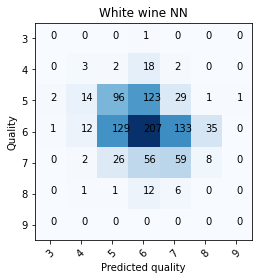

Red wine featutres: [4, 10]
 === NN Red wine ===
Accuracy Score:         40.31%
Cohen Kappa Score:       9.42%
Balanced Acc. Score:    21.95%
Our Score:              63.28%


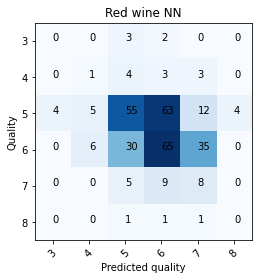

In [14]:
# NN
print(f'White wine featutres: {white_wine.best_features}')
white_wine_true, white_wine_pred = nearest_neighbor_classifier(white_wine)
print_results('NN White wine', white_wine_true, white_wine_pred)
draw_confusion_matrix(white_wine_true, white_wine_pred, 'White wine NN')


print(f'Red wine featutres: {red_wine.best_features}')
red_wine_true, red_wine_pred = nearest_neighbor_classifier(red_wine)
print_results('NN Red wine', red_wine_true, red_wine_pred)
draw_confusion_matrix(red_wine_true, red_wine_pred, 'Red wine NN')

scores['NN'] = {}
scores['NN']['white'] = wine_score(white_wine_true, white_wine_pred)
scores['NN']['red'] = wine_score(red_wine_true, red_wine_pred)




# k-NN

White wine featutres: [4, 7]
best k = 16
 === k-NN White wine ===
Accuracy Score:         43.67%
Cohen Kappa Score:       7.30%
Balanced Acc. Score:    20.90%
Our Score:              68.11%


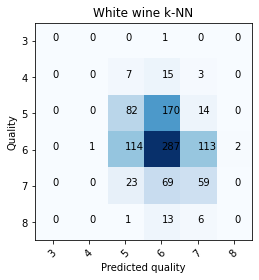

Red wine featutres: [4, 10]
best k = 16
 === k-NN Red wine ===
Accuracy Score:         49.06%
Cohen Kappa Score:      14.81%
Balanced Acc. Score:    20.72%
Our Score:              70.94%


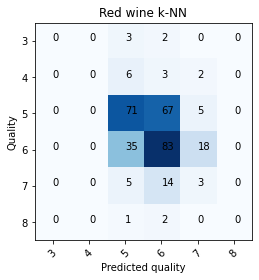

In [15]:
# k-nn

print(f'White wine featutres: {white_wine.best_features}')
#finding best k
best_k = None
best_score = None
for k in range(1, 20):
    true, pred = k_nearest_neighbor_classifier(white_wine, k)
    score = wine_score(true, pred)
    if best_k is None or score > best_score:
        best_k = k
        best_score = score
print(f'best k = {best_k}')
white_wine_true, white_wine_pred = k_nearest_neighbor_classifier(white_wine, best_k)
print_results('k-NN White wine', white_wine_true, white_wine_pred)
draw_confusion_matrix(white_wine_true, white_wine_pred, 'White wine k-NN')


print(f'Red wine featutres: {red_wine.best_features}')
#finding best k
best_k = None
best_score = None
for k in range(1, 20):
    true, pred = k_nearest_neighbor_classifier(white_wine, k)
    score = wine_score(true, pred)
    if best_k is None or score > best_score:
        best_k = k
        best_score = score
print(f'best k = {best_k}')
red_wine_true, red_wine_pred = k_nearest_neighbor_classifier(red_wine, best_k)
print_results('k-NN Red wine', red_wine_true, red_wine_pred)
draw_confusion_matrix(red_wine_true, red_wine_pred, 'Red wine k-NN')

scores['k-NN'] = {}
scores['k-NN']['white'] = wine_score(white_wine_true, white_wine_pred)
scores['k-NN']['red'] = wine_score(red_wine_true, red_wine_pred)

# NM

NM White wine - featutres: [4, 7]
 === NM White wine ===
Accuracy Score:         18.88%
Cohen Kappa Score:       4.26%
Balanced Acc. Score:    13.19%
Our Score:              34.13%


C:\Users\janje\miniconda3\envs\smpd\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


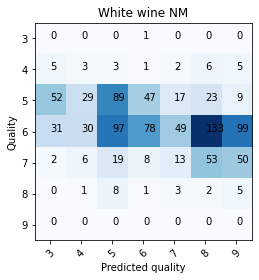

NM Red wine - featutres: [4, 10]
 === NM Red wine ===
Accuracy Score:         40.00%
Cohen Kappa Score:      18.49%
Balanced Acc. Score:    26.35%
Our Score:              58.28%


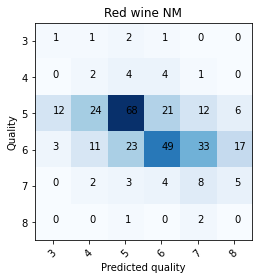

In [16]:
# nm
print(f'NM White wine - featutres: {white_wine.best_features}')
white_nm_true, white_nm_pred = nearest_mean_classifier(white_wine)
print_results('NM White wine', white_nm_true, white_nm_pred)
draw_confusion_matrix(white_nm_true, white_nm_pred, 'White wine NM')

print(f'NM Red wine - featutres: {red_wine.best_features}')
red_nm_true, red_nm_pred = nearest_mean_classifier(red_wine)
print_results('NM Red wine', red_nm_true, red_nm_pred)
draw_confusion_matrix(red_nm_true, red_nm_pred, 'Red wine NM')


scores['NM'] = {}
scores['NM']['white'] = wine_score(white_nm_true, white_nm_pred)
scores['NM']['red'] = wine_score(red_nm_true, red_nm_pred)

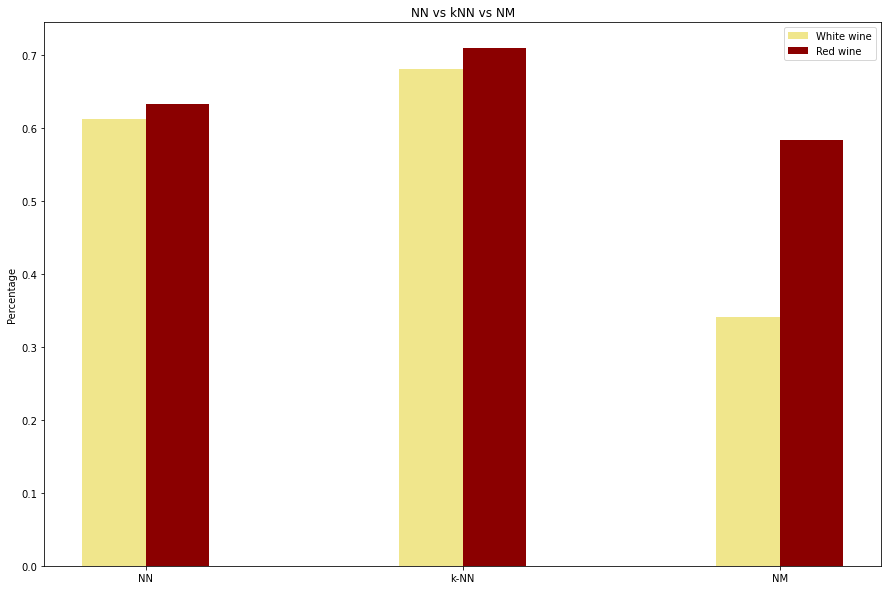

In [23]:
import matplotlib.pyplot as plt

# Labels
names = [key for key in scores.keys()]
x = np.arange(len(names))

# White wine accuracies
white_wine_acc = [value['white'] for value in scores.values()]

# Red wine accuracies
red_wine_acc = [value['red'] for value in scores.values()]

# Width of bars
width = 0.20

# Plot
fig, ax = plt.subplots()
white_bars = ax.bar(x - width/2, white_wine_acc, width, label='White wine', color='khaki')
red_bars = ax.bar(x + width/2, red_wine_acc, width, label='Red wine', color='darkred')

ax.set_title('NN vs kNN vs NM')
ax.set_ylabel('Percentage')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

fig.set_figheight(10)
fig.set_figwidth(15)

plt.show()

# Wnioski (?)

In [ ]:
print(scores)